In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime
import time
import math

In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import functional
from torchvision.transforms import v2

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(500)

In [4]:
wd = os.getcwd()

## Import Swin_V2 Model

In [5]:
from torchvision.models import swin_v2_t, Swin_V2_T_Weights

In [6]:
swin_model = swin_v2_t(weights=Swin_V2_T_Weights.DEFAULT)
preprocess = Swin_V2_T_Weights.DEFAULT.transforms()

In [7]:
preprocess

ImageClassification(
    crop_size=[256]
    resize_size=[260]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Load and Process Data

In [8]:
# Class representing a set
class WeedsDataset():
    def __init__(self, labels, img_dir, transform = None):
        self.labels = pd.read_csv(labels)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = self.labels[['Label','Species']].drop_duplicates().sort_values(by = 'Label').reset_index(drop = True)['Species']
        self.data = []
        self.train = []
        self.validation = []
        self.test = []
        
    # Load entire dataset into memory
    def __loaddata__(self):
        for row in self.labels.itertuples():
            filename = row.Filename
            label = torch.tensor(row.Label)
            img_path = os.path.join(self.img_dir, filename)
            image = self.transform(torchvision.io.read_image(img_path))
            self.data.append([image,label])
        del self.labels
        print('Data has been loaded')

    # Split into train/validation/test
    def __split__(self):
        random.shuffle(self.data)
        n = len(self.data)
        n_train = round(n * 0.8)
        n_valid = round(n * 0.1)
        
        self.train = self.data[:n_train]
        self.valid = self.data[n_train:n_train + n_valid]
        self.test = self.data[n_train + n_valid:]
        del self.data
        
        print('Data has been split')
        print('Size of training set is {}'.format(len(self.train)))
        print('Size of validation set is {}'.format(len(self.valid)))
        print('Size of test set is {}'.format(len(self.test)))

    # Augment with rotations and gaussian noise
    def __augment__(self, frac):
        n = round(len(self.train) * frac / 5)
        rotate_90 = random.sample(self.train, n)
        for row in rotate_90:
            image = row[0]
            row[0] = functional.rotate(image, 90)
        rotate_180 = random.sample(self.train, n)
        for row in rotate_180:
            image = row[0]
            row[0] = functional.rotate(image, 180)
        rotate_270 = random.sample(self.train,n)
        for row in rotate_270:
            image = row[0]
            row[0] = functional.rotate(image, 270)
        self.train += rotate_90 + rotate_180 + rotate_270
        gaussian = v2.GaussianNoise(0,0.08,False)
        noise = random.sample(self.train, 2*n)
        for row in noise:
            image = row[0]
            row[0] = gaussian(image)
        self.train += noise
        
        print('Data has been augmented')
        print('Size of training set is {}'.format(len(self.train)))
        
    # Get item from sets, format is (image,label)
    def __getitem__(self, idx, split):
        if split == 'train':
            item = self.train[idx]
        elif split == 'valid':
            item = self.valid[idx]
        elif split == 'test':
            item = self.test[idx]
        return item[0], item[1]

In [9]:
# Run functions to load and process data
weeds = WeedsDataset(rf'{wd}\mini_labels.csv', rf'{wd}\images', preprocess)
weeds.__loaddata__()
weeds.__split__()
weeds.__augment__(0.5)

Data has been loaded
Data has been split
Size of training set is 72
Size of validation set is 9
Size of test set is 9
Data has been augmented
Size of training set is 107


In [10]:
# Functions to convert the label back into the class
def convert_label(label, dataset):
    return dataset.classes[label.item()]

def convert_labels(labels,dataset):
    lst = []
    for label in labels:
        data_class = convert_label(label,dataset)
        lst.append(data_class)
    return lst

## Load Data

In [11]:
# Sends image and label tensors to gpu
def get_batch(dataset, current_index, batch_size):
    images,labels = zip(*dataset[current_index:current_index+batch_size])
    return torch.stack(images, dim = 0), torch.stack(labels)

In [12]:
# Check that everything is working properly
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Create a grid from the images and show them
#images,labels = get_batch(weeds.train, 1000, 32)
#img_grid = torchvision.utils.make_grid(images.cpu())
#matplotlib_imshow(img_grid, one_channel=True)
#print(convert_labels(labels.cpu(),weeds))

## Replacing Classification Head

In [13]:
for param in swin_model.parameters():
    param.requires_grad = False
layers = []
layers.append(nn.Linear(in_features = 768, out_features = 256, bias = True))
layers.append(nn.ReLU())
layers.append(nn.Linear(in_features = 256, out_features = 9, bias = True))
swin_model.head = nn.Sequential(*layers)

In [14]:
#info.summary(swin_model)

## Training

## Evaluation

In [15]:
# Lowest validation loss is 0.2069510916610145 at epoch 91

In [16]:
swin_model.load_state_dict(torch.load('finalmodel\model_20250222_211532_91', weights_only = True, map_location = torch.device('cpu')))

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\simzi\AppData\Local\Temp\ipykernel_21900\1757134040.py:1: SyntaxWarning: invalid escape sequence '\m'
  swin_model.load_state_dict(torch.load('finalmodel\model_20250222_211532_91', weights_only = True, map_location = torch.device('cpu')))


<All keys matched successfully>

In [17]:
def evaluate(batch_size):
    start = time.perf_counter()
    total = 0
    correct = 0
    batches = math.floor(len(weeds.test)/batch_size)
    current_index = 0
    
    for i in range(batches):
        inputs,labels = get_batch(weeds.train, current_index, batch_size)
        current_index += batch_size
        prediction = torch.argmax(swin_model(inputs), dim = 1)
        correct += sum(prediction == labels).item()
        total += batch_size

    remainder = len(weeds.test)%batch_size
    if remainder != 0:
        inputs,labels = get_batch(weeds.train, current_index, remainder)
        prediction = torch.argmax(swin_model(inputs), dim = 1)
        correct += sum(prediction == labels).item()
        total += remainder

    accuracy = 100*correct/total
    print ('Accuracy is {}%'.format(accuracy))
    end = time.perf_counter()
    print('Time taken is {}'.format(end-start))
    
    return 

In [18]:
with torch.no_grad():
    swin_model.eval()
    evaluate(20)

Accuracy is 88.88888888888889%
Time taken is 1.8885250999999812


In [19]:
weeds.train[0][1] # actual

tensor(6)

In [20]:
torch.argmax(swin_model(get_batch(weeds.train,0,1)[0])) # prediction

tensor(6)

In [21]:
# Accuracy is 92.58%

In [22]:
torch.save(swin_model, 'trained_model\weedsv1.pt')

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\simzi\AppData\Local\Temp\ipykernel_21900\3095721756.py:1: SyntaxWarning: invalid escape sequence '\w'
  torch.save(swin_model, 'trained_model\weedsv1.pt')
C:\Users\simzi\AppData\Local\Temp\ipykernel_21900\3095721756.py:1: SyntaxWarning: invalid escape sequence '\w'
  torch.save(swin_model, 'trained_model\weedsv1.pt')


RuntimeError: Parent directory trained_model does not exist.

## Evaluation for F1 Score

In [25]:
import numpy as np
import torch
import time
import math
from sklearn.metrics import confusion_matrix

# Formula for F1: (2 * FP) / (2 * TP + FP + FN) OR 2 * (Precision * Recall) / (Precision + Recall)
# Formula for Precision: TP / (TP + FP)
# Formula for Recall: TP / (TP + FN)

num_classes = len(weeds.classes)
num_classes # Verify if there are 9 classes

def evaluate_f1(batch_size):
    start = time.perf_counter()
    total = 0
    correct = 0
    batches = math.floor(len(weeds.test) / batch_size)
    current_index = 0
    
    all_preds = []
    all_labels = []

    # Split into batches
    for i in range(batches):
        inputs, labels = get_batch(weeds.train, current_index, batch_size)
        current_index += batch_size
        prediction = torch.argmax(swin_model(inputs), dim=1)
        
        correct += sum(prediction == labels).item()
        total += batch_size

        all_preds.extend(prediction.numpy())
        all_labels.extend(labels.numpy())

    # Handle remainder batch
    remainder = len(weeds.test) % batch_size
    if remainder != 0:
        inputs, labels = get_batch(weeds.train, current_index, remainder)
        prediction = torch.argmax(swin_model(inputs), dim=1)
        
        correct += sum(prediction == labels).item()
        total += remainder

        all_preds.extend(prediction.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print('Accuracy is {}%'.format(accuracy))

    # Compute Micro-Averaged F1-Score
    num_classes = len(weeds.classes) 
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
    print(conf_matrix)

    total_TP = 0
    total_FP = 0
    total_FN = 0

    # Generate confuction matriz
    for i in range(num_classes):
        TP = conf_matrix[i, i]  # True Positives
        FP = np.sum(conf_matrix[:, i]) - TP  # False Positives
        FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives

        total_TP += TP
        total_FP += FP
        total_FN += FN

    micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    micro_f1 = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    print(f"Micro Precision: {micro_precision:.4f}")
    print(f"Micro Recall: {micro_recall:.4f}")
    print(f"Micro F1-score: {micro_f1:.4f}")

    end = time.perf_counter()
    print('Time taken is {}'.format(end - start))


In [26]:
with torch.no_grad():
    swin_model.eval()
    evaluate_f1(20)

Accuracy is 88.88888888888889%
[[2 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]
Micro Precision: 0.8889
Micro Recall: 0.8889
Micro F1-score: 0.8889
Time taken is 1.181366799999978


## Augmentation with ColorJitter

In [67]:
import torch
import numpy as np
import torchvision.transforms as transforms
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Define the ColorJitter transformation
color_jitter = transforms.ColorJitter(brightness = 0.3, contrast = 0.2, saturation = 0.3, hue = 0.1)

def visualize_images(original, augmented):
    # Visualize the original and augmented images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Convert tensor images to numpy arrays for visualization
    original_img = original.permute(1, 2, 0).numpy()  # Convert from C x H x W to H x W x C
    augmented_img = augmented.permute(1, 2, 0).numpy()

    # Normalize the images to [0, 1] range if required (since they may be in [0, 255] or [-1, 1] range)
    original_img = np.clip(original_img, 0, 1)
    augmented_img = np.clip(augmented_img, 0, 1)

    # Display the images
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(augmented_img)
    axes[1].set_title('Augmented Image')
    axes[1].axis('off')

    plt.show() 
    plt.close(fig) 

def augment_cj(batch_size):
    start = time.perf_counter()
    total = 0
    correct = 0
    batches = math.floor(len(weeds.test) / batch_size)
    current_index = 0

    all_preds = []  
    all_labels = []

    for i in range(batches):
        # Get batch of data
        inputs, labels = get_batch(weeds.train, current_index, batch_size)
        current_index += batch_size

        # Check the range before normalization
        print(f"Before normalization: min={inputs.min()}, max={inputs.max()}")

        # Normalize the entire batch (to [0, 1] range)
        eps = 1e-8  
        inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min() + eps)

        # Check after normalization
        print(f"After normalization: min={inputs.min()}, max={inputs.max()}")

        # Select the first image from the batch for visualization
        original_image = inputs[0]  
        
        # Apply ColorJitter to augment the images
        augmented_image = color_jitter(original_image) 

        # Visualize the original vs augmented image
        visualize_images(original_image, augmented_image)
        
        # Check if any pixel values in inputs are negative
        if (inputs < 0).any():
            print(f"Warning: Negative pixel values detected in inputs at batch {i}")
            negative_pixel_indices = np.where(inputs.numpy() < 0)
            print(f"Negative pixel indices at batch {i}: {negative_pixel_indices}")
        
        # Forward pass through the model
        prediction = torch.argmax(swin_model(inputs), dim=1)

        # Check for negative values in the predictions 
        if (prediction < 0).any():
            print(f"Warning: Negative values detected in predictions at batch {i}")
            
        # Store the predictions and labels for further analysis
        all_preds.extend(prediction.numpy())
        all_labels.extend(labels.numpy())

    # Check for negative values in all predictions and labels
    if any(val < 0 for val in all_preds):
        print("Warning: Negative values detected in all_preds!")
    if any(val < 0 for val in all_labels):
        print("Warning: Negative values detected in all_labels!")
    else:
        print("There are no negative values detected")
        
    end = time.perf_counter()
    print('Time taken is {}'.format(end - start))

    return all_preds, all_labels


Before normalization: min=-2.1179039478302, max=2.640000104904175
After normalization: min=0.0, max=1.0


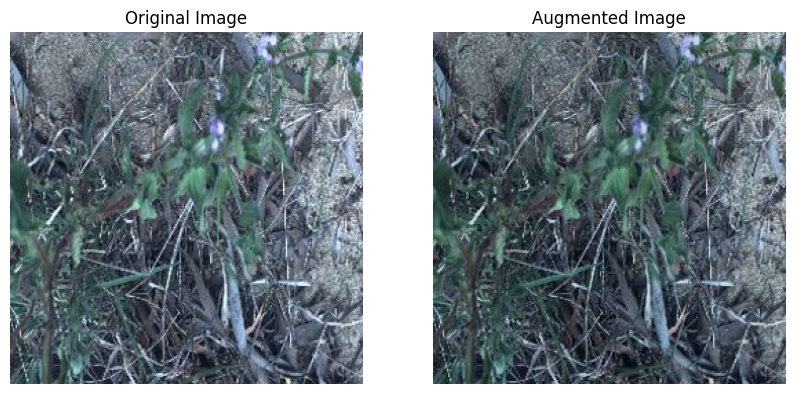

Before normalization: min=-2.3590426445007324, max=2.9218642711639404
After normalization: min=0.0, max=1.0


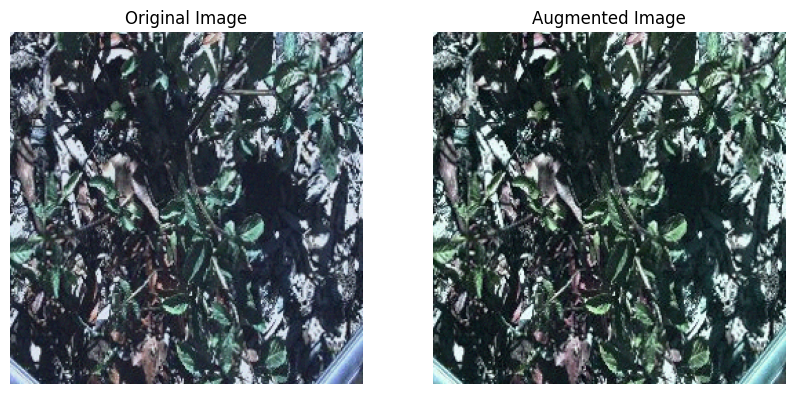

Before normalization: min=-2.1179039478302, max=2.640000104904175
After normalization: min=0.0, max=1.0


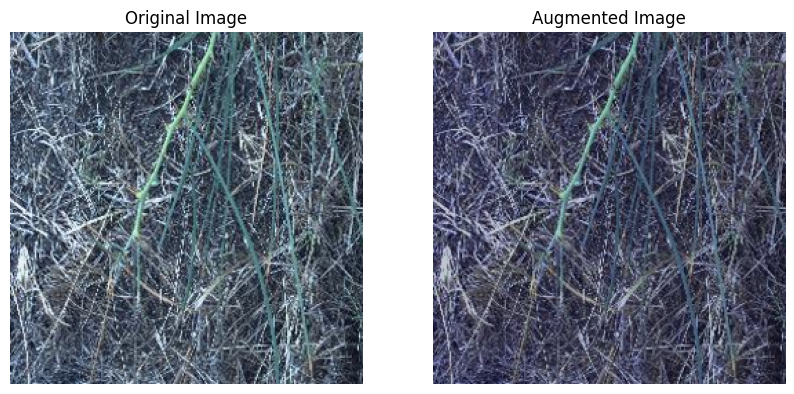

Before normalization: min=-2.1179039478302, max=2.640000104904175
After normalization: min=0.0, max=1.0


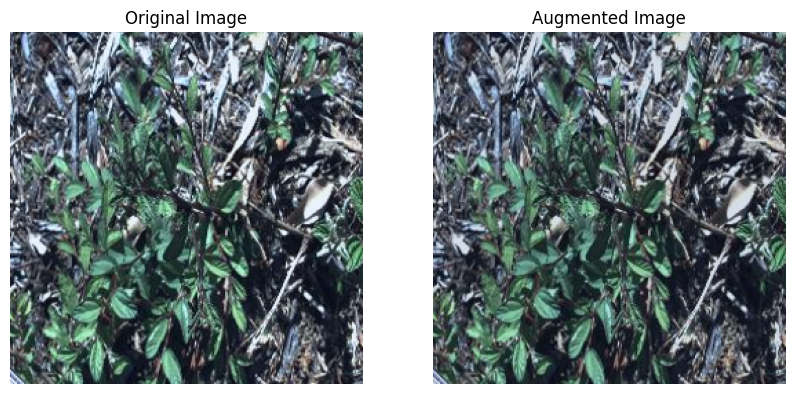

Before normalization: min=-2.1179039478302, max=2.640000104904175
After normalization: min=0.0, max=1.0


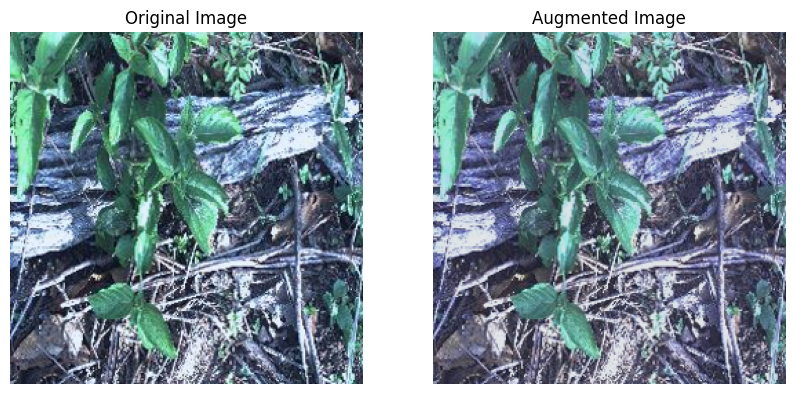

Before normalization: min=-2.0357141494750977, max=2.640000104904175
After normalization: min=0.0, max=1.0


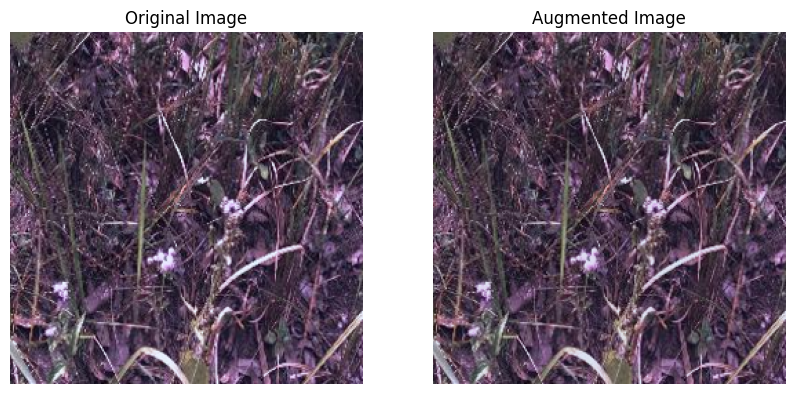

Before normalization: min=-2.3324930667877197, max=2.9351301193237305
After normalization: min=0.0, max=1.0


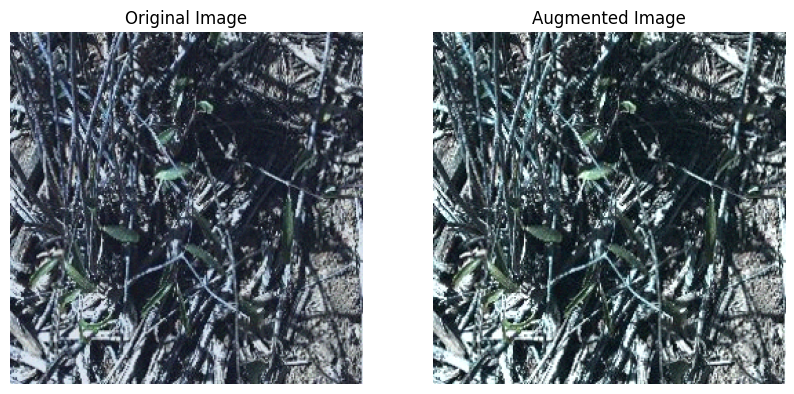

Before normalization: min=-2.1179039478302, max=2.640000104904175
After normalization: min=0.0, max=1.0


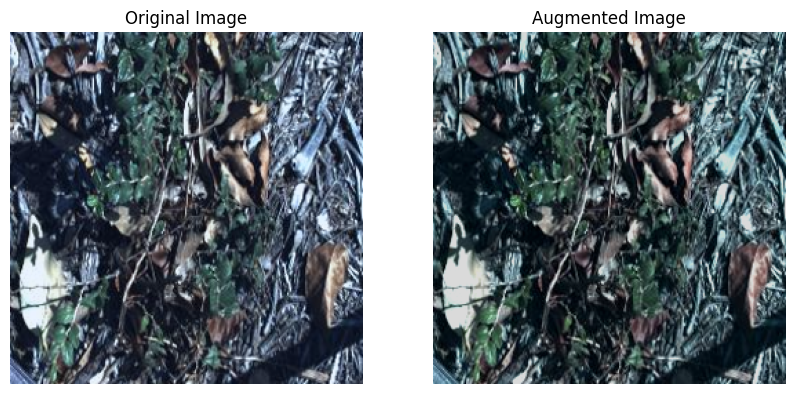

Before normalization: min=-2.1179039478302, max=2.640000104904175
After normalization: min=0.0, max=1.0


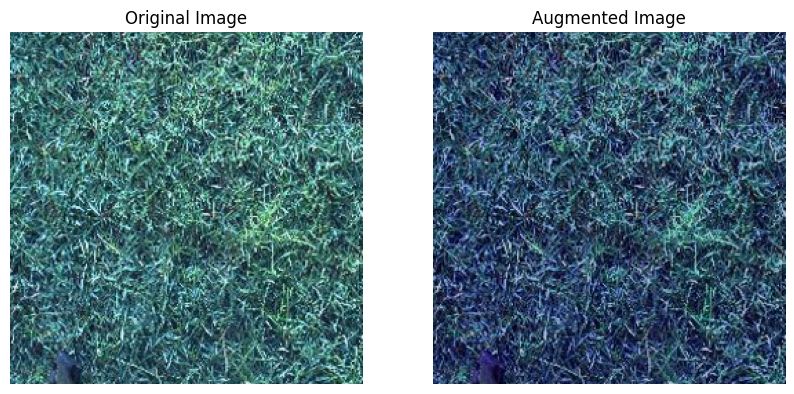

There are no negative values detected
Time taken is 4.873348600000099


In [68]:
with torch.no_grad():
    swin_model.eval()
    augment_cj(1)